# Santander Customer Transaction Prediction

This is a notebook to solve kaggle challenge of santander customer transaction target classification.
Description is not that clear, but it seems like a classification challenge

Area under ROC curve is the evaluation criteria for this problem

## Importing data and checking for overall data quality

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# import train and test datasets

train_df = pd.read_csv('./inputs/train.csv')
test_df = pd.read_csv('./inputs/test.csv')

combine = [train_df, test_df]

It seems that test and train datasets have the same number of instances (200k instances). There is an additional column in train dataset, which I presume is the labeled predicted variable to train our prediction models

In [3]:
for df in combine:
    print(df.shape)

(200000, 202)
(200000, 201)


In [4]:
# Let's check for the predicted variable column name
set(train_df.columns) - set(test_df.columns)

{'target'}

In [5]:
# It's also not clear what each feature means, we have around 199 features, which is really a lot of models
set(test_df.columns)

{'ID_code',
 'var_0',
 'var_1',
 'var_10',
 'var_100',
 'var_101',
 'var_102',
 'var_103',
 'var_104',
 'var_105',
 'var_106',
 'var_107',
 'var_108',
 'var_109',
 'var_11',
 'var_110',
 'var_111',
 'var_112',
 'var_113',
 'var_114',
 'var_115',
 'var_116',
 'var_117',
 'var_118',
 'var_119',
 'var_12',
 'var_120',
 'var_121',
 'var_122',
 'var_123',
 'var_124',
 'var_125',
 'var_126',
 'var_127',
 'var_128',
 'var_129',
 'var_13',
 'var_130',
 'var_131',
 'var_132',
 'var_133',
 'var_134',
 'var_135',
 'var_136',
 'var_137',
 'var_138',
 'var_139',
 'var_14',
 'var_140',
 'var_141',
 'var_142',
 'var_143',
 'var_144',
 'var_145',
 'var_146',
 'var_147',
 'var_148',
 'var_149',
 'var_15',
 'var_150',
 'var_151',
 'var_152',
 'var_153',
 'var_154',
 'var_155',
 'var_156',
 'var_157',
 'var_158',
 'var_159',
 'var_16',
 'var_160',
 'var_161',
 'var_162',
 'var_163',
 'var_164',
 'var_165',
 'var_166',
 'var_167',
 'var_168',
 'var_169',
 'var_17',
 'var_170',
 'var_171',
 'var_172',
 'va

We can see that all features are float-like, both on test and train datasets

In [6]:
# Let's check for data types
for df in combine:
    types_df = (
        pd.DataFrame(train_df.dtypes, columns=["dtype"])
        .reset_index()
        .rename(columns={'index':'feature'})
    )
    mask = ~((types_df["feature"] == "target") | (types_df["feature"] == "ID_code"))
    print(types_df.loc[mask].groupby("dtype").count())

         feature
dtype           
float64      200
         feature
dtype           
float64      200


### Key takeaways
- We are creating a binary classifier based on 200 input features, with model selection based on ROC curve
- Train dataset seems unbalanced, with 10% instances falling under the `1` category and 90% falling under `0` category
- Oddly, train and test data have no null values

In [7]:
# Let's investigate our predicted variable
train_df['target'].value_counts()

0    179902
1     20098
Name: target, dtype: int64

In [8]:
# Let's check for null values

print('train_df')
print(train_df.drop(["ID_code","target"],axis='columns').isnull().sum().sort_values(ascending=False))

print('\ntest_df')
print(test_df.drop(["ID_code"],axis='columns').isnull().sum().sort_values(ascending=False))

train_df
var_0      0
var_137    0
var_127    0
var_128    0
var_129    0
          ..
var_69     0
var_70     0
var_71     0
var_72     0
var_199    0
Length: 200, dtype: int64

test_df
var_0      0
var_137    0
var_127    0
var_128    0
var_129    0
          ..
var_69     0
var_70     0
var_71     0
var_72     0
var_199    0
Length: 200, dtype: int64


## Testing some early correlations

Let's find out which features are mostly correlated with the predicted variable

First, we will use sklearn scalers to normalize data for the same 0-1 range our predicted variable is. Then we will use pandas built in pearson correlation to test

Indeed, predictors are really out of scale

In [9]:
train_df.drop(["ID_code"],axis='columns').describe().T

,count,mean,std,min,25%,50%,75%,max
target,200000.0,0.100490,0.300653,0.0000,0.000000,0.00000,0.000000,1.0000
var_0,200000.0,10.679914,3.040051,0.4084,8.453850,10.52475,12.758200,20.3150
var_1,200000.0,-1.627622,4.050044,-15.0434,-4.740025,-1.60805,1.358625,10.3768
var_2,200000.0,10.715192,2.640894,2.1171,8.722475,10.58000,12.516700,19.3530
var_3,200000.0,6.796529,2.043319,-0.0402,5.254075,6.82500,8.324100,13.1883
...,...,...,...,...,...,...,...,...
var_195,200000.0,-0.142088,1.429372,-5.2610,-1.170700,-0.17270,0.829600,4.2729
var_196,200000.0,2.303335,5.454369,-14.2096,-1.946925,2.40890,6.556725,18.3215
var_197,200000.0,8.908158,0.921625,5.9606,8.252800,8.88820,9.593300,12.0004
var_198,200000.0,15.870720,3.010945,6.2993,13.829700,15.93405,18.064725,26.0791


Before we use a scaler, lets test whether predictors are normally distributed or not

<AxesSubplot:>

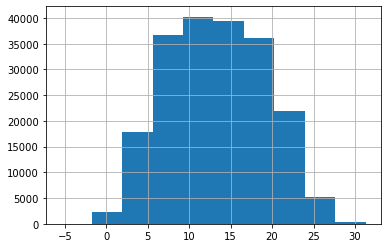

In [10]:
train_df["var_20"].hist()

As most of them seem normally distributed, let's try a simple standard scaler

In [11]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X = train_df.drop(["ID_code","target"],axis=1)
y = train_df["target"]

scaler.fit(X)

StandardScaler()

In [12]:
X_scaled = scaler.transform(X)
X_test = scaler.transform(test_df.drop(["ID_code"],axis=1))

In [13]:
df_scaled = pd.DataFrame(X_scaled, columns=X.columns)
df_scaled["target"] = y

In [14]:
corr_coef = df_scaled.corr()["target"].drop(index="target")

In [15]:
corr_coef = corr_coef.reset_index().rename({"index": "feature","target": "target_correlation"},axis=1)

In [16]:
corr_coef["feature_number"] = corr_coef["feature"].str.split("var_").map(lambda x: x[1])

In [17]:
corr_coef.sort_values(by="target_correlation",ascending=False)

,feature,target_correlation,feature_number
6,var_6,0.066731,6
110,var_110,0.064275,110
53,var_53,0.063399,53
26,var_26,0.062422,26
22,var_22,0.060558,22
...,...,...,...
76,var_76,-0.061917,76
146,var_146,-0.063644,146
12,var_12,-0.069489,12
139,var_139,-0.074080,139


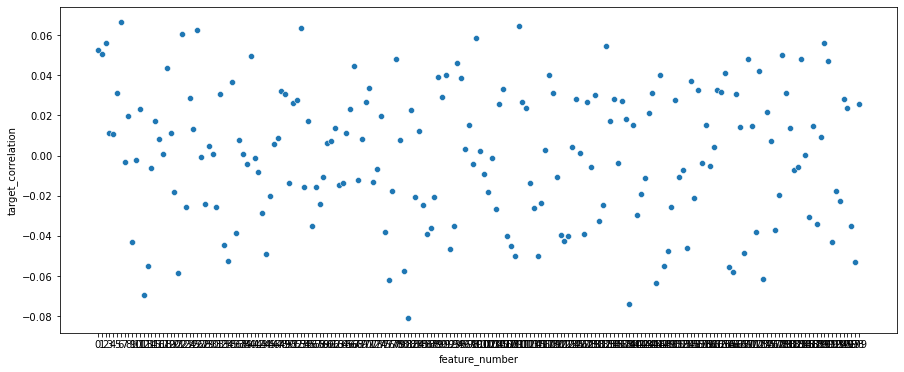

In [18]:
fig = plt.figure(figsize=(15,6))
sns.scatterplot(x="feature_number",y="target_correlation",data=corr_coef)
plt.show()

In [19]:
df_scaled.describe().T

,count,mean,std,min,25%,50%,75%,max
var_0,200000.0,7.007542e-16,1.000003,-3.378739,-0.732248,-0.051040,0.683637,3.169391
var_1,200000.0,-3.323231e-17,1.000003,-3.312510,-0.768488,0.004832,0.737339,2.964030
var_2,200000.0,-6.781659e-16,1.000003,-3.255758,-0.754563,-0.051192,0.682160,3.270797
var_3,200000.0,-6.464329e-17,1.000003,-3.345903,-0.754879,0.013934,0.747595,3.128139
var_4,200000.0,-6.293563e-16,1.000003,-3.698703,-0.736322,0.018431,0.728703,3.445820
...,...,...,...,...,...,...,...,...
var_196,200000.0,4.137579e-17,1.000003,-3.027477,-0.779241,0.019354,0.779815,2.936766
var_197,200000.0,-7.417189e-16,1.000003,-3.198224,-0.711091,-0.021655,0.743408,3.355213
var_198,200000.0,1.369505e-16,1.000003,-3.178883,-0.677869,0.021033,0.728678,3.390432
var_199,200000.0,3.363393e-17,1.000003,-3.403554,-0.755120,0.048571,0.782079,3.049173


<AxesSubplot:>

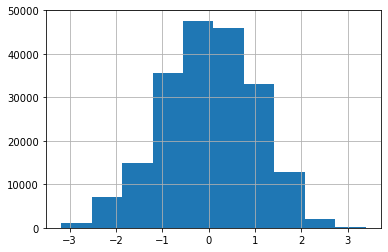

In [20]:
df_scaled["var_198"].hist()

<AxesSubplot:>

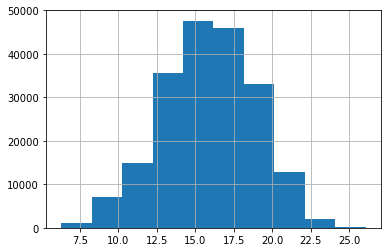

In [21]:
train_df["var_198"].hist()

### Key takeways
- Predictors are poorly correlated to target variable
- There are too many predictors, all of them seems normally distributed and are standardized
- none of them are quite correlated or interpretable, so I suppose many are correlated
- This seems a case to apply Principal Component Analysis to reduce the number of predictors into uncorrelated ortonormal predictors

## Principal Component Analysis

- Even after PCA transformation, we doesn't seem to find features that hold the most variance
- Solution indicates that we should go with a model that holds feature selection capabilities inside, such as bagging and boosting (e.g., ensemble methods)

In [22]:
from sklearn.decomposition import PCA

In [23]:
X_scaled.shape

(200000, 200)

In [24]:
pca_200 = PCA(n_components=200,random_state=2023)
pca_200.fit(X_scaled)
X_pca_200 = pca_200.transform(X_scaled)

In [25]:
X_pca_200_test = pca_200.transform(X_test)

In [26]:
np.cumsum(pca_200.explained_variance_ratio_ *100)

array([  0.61130811,   1.14157523,   1.67143738,   2.20111009,
         2.7299043 ,   3.25817314,   3.78612075,   4.31354723,
         4.84011279,   5.36639612,   5.89195089,   6.41694488,
         6.94154729,   7.46523443,   7.98881576,   8.51231944,
         9.03504658,   9.55742854,  10.07935506,  10.6011815 ,
        11.1226784 ,  11.64369628,  12.16442547,  12.68466709,
        13.20464246,  13.72409229,  14.24339123,  14.7626472 ,
        15.28139354,  15.7997422 ,  16.31803149,  16.83586168,
        17.35325601,  17.87017734,  18.38680951,  18.90340684,
        19.41964869,  19.93562537,  20.45109374,  20.96642941,
        21.48137805,  21.99587555,  22.51013444,  23.02424508,
        23.53794857,  24.05139476,  24.5645775 ,  25.07748001,
        25.5902648 ,  26.10277843,  26.61468509,  27.12645967,
        27.63809706,  28.14960006,  28.66054105,  29.1711723 ,
        29.6817604 ,  30.19207635,  30.70220686,  31.21202931,
        31.72156228,  32.23083066,  32.73994226,  33.24

## Exploring linearity
- By analyzing a small subset of features pairwise with the target variable result, we can observe that it doesn't seem to exist a linear divider that can classify the target variable
- Non-linear models such as k-NN, ensemble and decision trees seem more appropriate to solve this model 

In [27]:
df_pca = pd.DataFrame(X_pca_200, columns=X.columns)
df_pca["target"] = y

In [28]:
df_plot = df_pca[["var_" + str(x) for x in range(1,11)] + ['target']].sample(n=100, random_state=2023)

In [29]:
df_plot

,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,target
82616,0.056827,-1.529857,-1.124084,-1.751348,-1.176860,-0.179208,-1.435029,0.225151,-0.302750,1.108621,0
75707,1.008442,1.285397,-0.547096,-0.651197,-0.317060,-0.743881,0.678740,0.527610,-0.309731,0.326439,0
107221,1.300660,-0.104395,-0.403884,0.816193,-0.633196,-0.902772,-0.132041,1.742809,-2.068961,-1.307464,0
164218,-0.535703,0.210143,-0.020374,0.507367,0.567295,0.050121,0.834378,0.753556,-1.236666,0.838876,0
71113,1.793252,1.043072,-1.022087,-0.223109,1.031174,-0.295820,0.374519,0.863153,-0.488353,-1.946533,0
...,...,...,...,...,...,...,...,...,...,...,...
2494,0.068161,-0.095652,-1.335627,0.155158,1.911164,-0.283653,0.123993,-0.674885,0.237691,-1.371419,1
25230,0.067285,0.656573,-0.377528,-0.496742,0.977184,-0.427551,-0.773285,-0.655252,-0.204412,0.420062,0
181799,-1.041040,0.589957,0.817643,-0.290748,-1.313707,0.536297,1.473519,0.179443,-0.351507,-1.186208,0
141891,0.449042,-0.351462,-0.149151,1.455522,-0.792038,1.135188,-1.240347,-0.996077,-0.937384,-0.601617,1


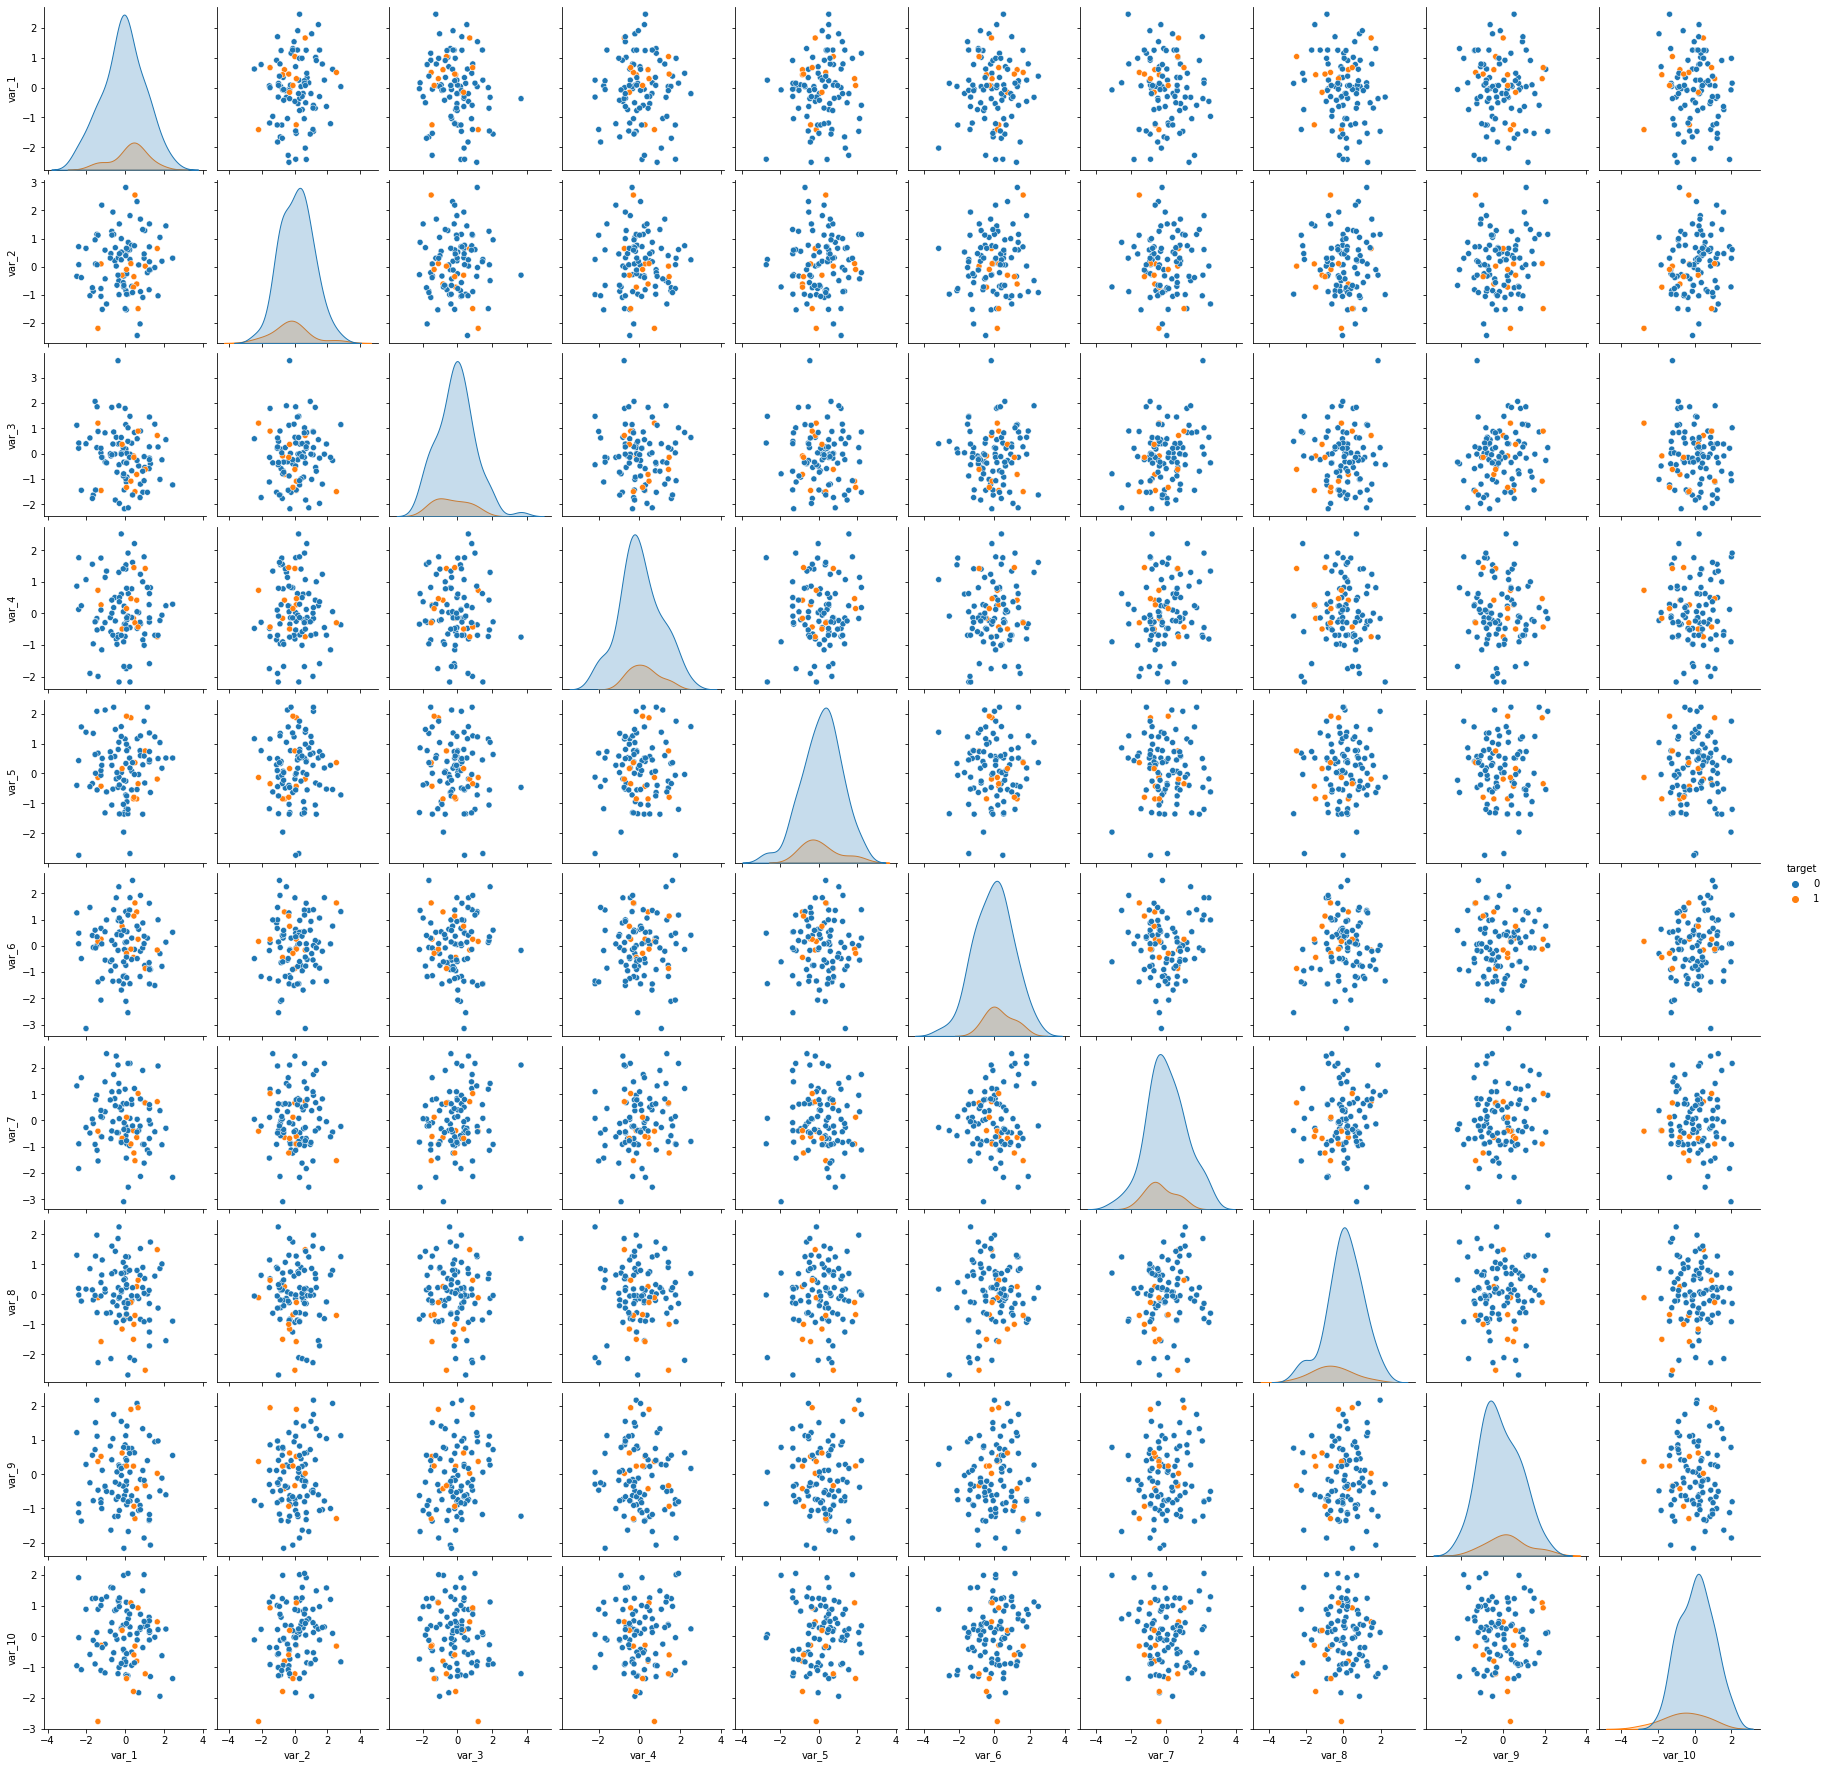

In [30]:
sns.pairplot(df_plot, hue='target')

KeyboardInterrupt: 

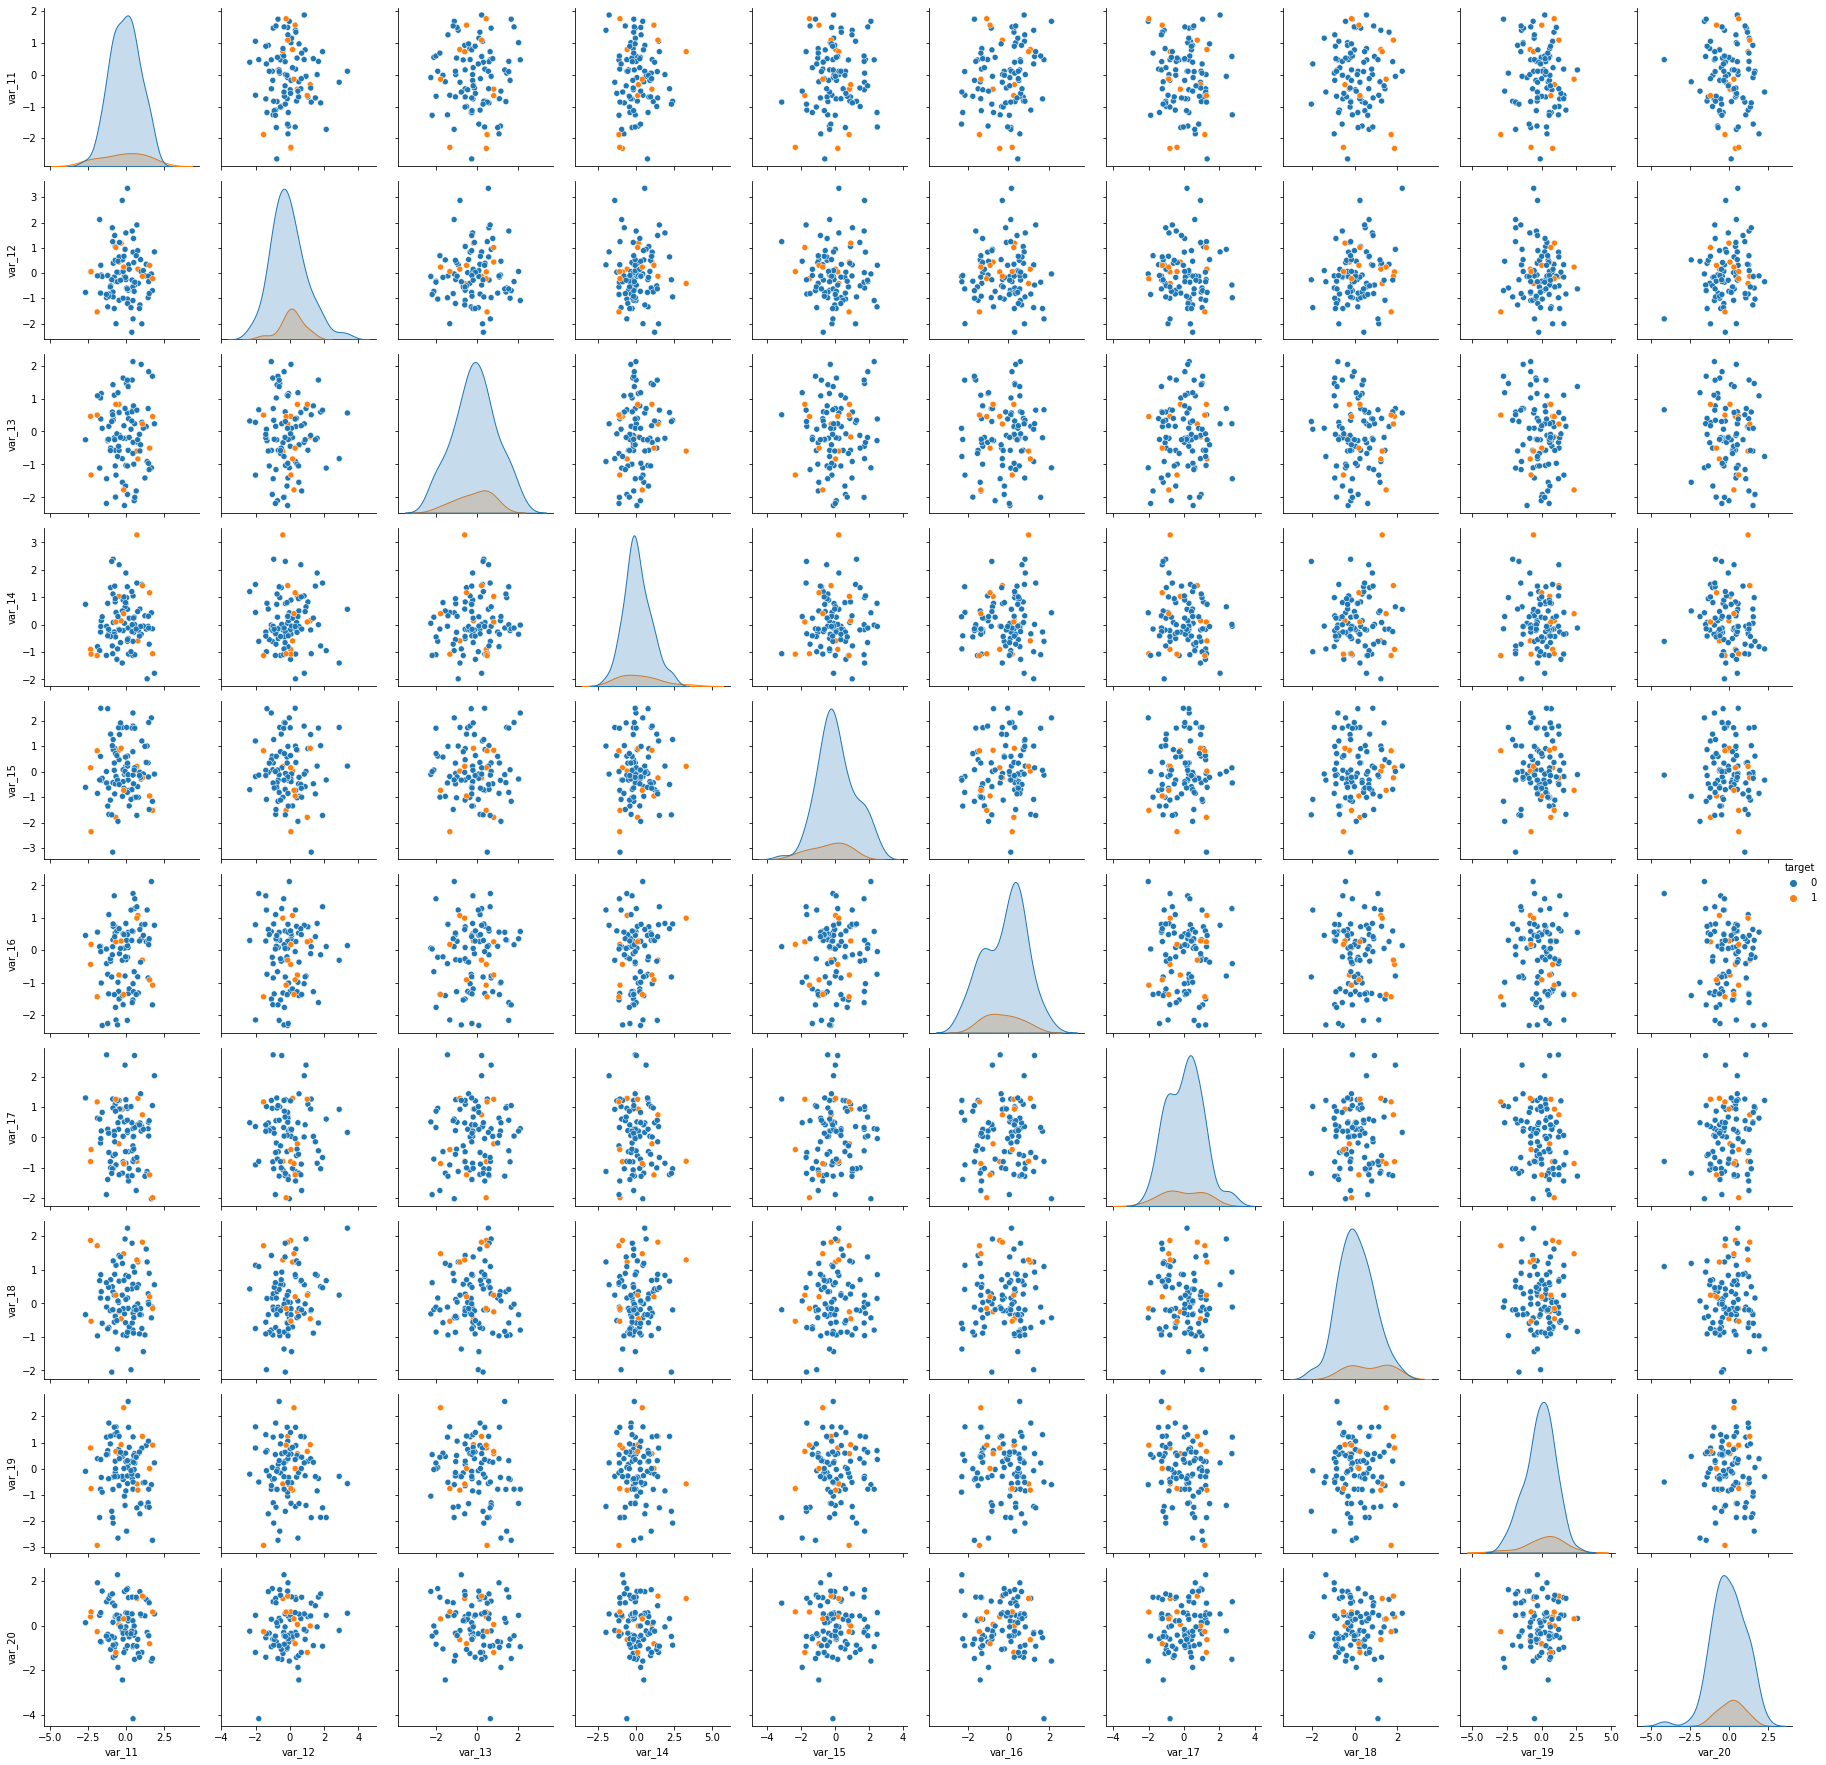

In [31]:
df_plot = df_pca[["var_" + str(x) for x in range(11,21)] + ['target']].sample(n=100, random_state=2023)
sns.pairplot(df_plot, hue='target')

In [ ]:
df_plot = df_pca[["var_" + str(x) for x in range(21,31)] + ['target']].sample(n=100, random_state=2023)
sns.pairplot(df_plot, hue='target')

## Modeling and testing some predictions

### Defining the train and test data splits

In [32]:
from sklearn.model_selection import train_test_split

In [33]:
X_train, X_test, y_train, y_test = train_test_split(
    df_pca.drop("target",axis=1),df_pca["target"], 
    test_size=0.3, random_state=2023)

In [34]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((140000, 200), (60000, 200), (140000,), (60000,))

### Let's start with a baseline dummy classifier

In [35]:
from sklearn.metrics import roc_curve, roc_auc_score

In [36]:
from sklearn.dummy import DummyClassifier

In [37]:
model = DummyClassifier(random_state=2023)
model.fit(X_train, y_train)

DummyClassifier(random_state=2023)

In [38]:
# returns for each instance the probability to belong to the target class 0 and 1
probs_positive_class = model.predict_proba(X_test)[:,1]

In [39]:
fpr, tpr, thresholds = roc_curve(y_test, probs_positive_class)

In [40]:
fpr

array([0., 1.])

In [41]:
tpr

array([0., 1.])

In [42]:
thresholds

array([1.10037143, 0.10037143])

In [43]:
auc_roc = roc_auc_score(y_test, probs_positive_class)

In [44]:
auc_roc

0.5

In [45]:
def make_roc_plot(fpr, tpr, auc_roc, model_name):
    plt.plot(fpr, tpr, label=f"{model_name}, AUC = {auc_roc:.2f}")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title("ROC Curves")
    plt.legend()

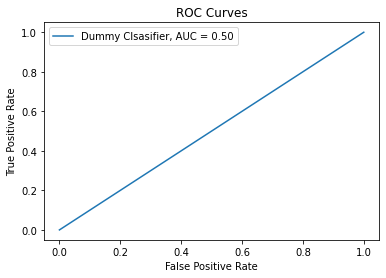

In [46]:
make_roc_plot(fpr,tpr,auc_roc,'Dummy Clsasifier')
plt.show()

## Let's evolve into some more interesting models

### Linear models

- Expected poor performance
- Maybe lower than dummy

In [47]:
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB

In [48]:
models = [
    (DummyClassifier(random_state=2023),'Dummy'),
    (LogisticRegression(random_state=2023),'Logistic Regression'),
    (SGDClassifier(random_state=2023),'SGD'),
    (Perceptron(random_state=2023),'Perceptron'),
    (LinearSVC(random_state=2023),'Linear SVM'),
    (GaussianNB(),'Naive Bayes'),
]

Dummy: 0.5
Logistic Regression: 0.8568585384560383
SGD: 0.8318737254904942
Perceptron: 0.7581467291987902


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Linear SVM: 0.8539039596232422
Naive Bayes: 0.878835569992355


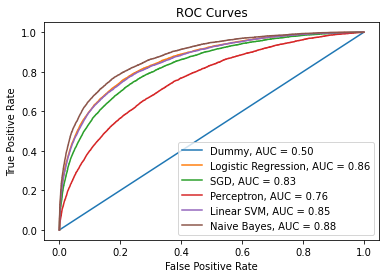

In [49]:
auc_scores = np.zeros(len(models))

for i in range(0,len(models)):
    model, name = models[i]
    model.fit(X_train, y_train)
    
    if hasattr(model,'decision_function'):
        y_score = model.decision_function(X_test)
    if hasattr(model,'predict_proba'):
        y_score = model.predict_proba(X_test)[:,1]
    
    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    auc_scores[i] = roc_auc_score(y_test, y_score)
    print(f"{name}: {auc_scores[i]}")
    make_roc_plot(fpr, tpr, auc_scores[i], name)
    
plt.show()

### Non-linear models
- Expected better performance than the linear models

In [50]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.svm import SVC 

In [51]:
models = [
    (DummyClassifier(random_state=2023),'Dummy'),
    (GaussianNB(),'Naive Bayes'),
    (DecisionTreeClassifier(max_depth = 200, random_state=2023),'Decision Tree'),
    (RandomForestClassifier(n_estimators=10, n_jobs=3, max_depth = 200, random_state=2023),'Random Forest'),
#     (GradientBoostingClassifier(n_estimators=10, random_state=2023),'Gradient Boosting'),
#     (BaggingClassifier(n_estimators=10,random_state=2023),'Bagging'),
#     (AdaBoostClassifier(n_estimators=10,random_state=2023),'AdaBoost'),
]

Dummy: 0.5
Naive Bayes: 0.878835569992355
Decision Tree: 0.6332879268358017
Random Forest: 0.7914290580362432


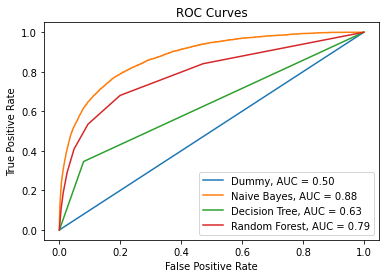

In [52]:
auc_scores = np.zeros(len(models))

for i in range(0,len(models)):
    model, name = models[i]
    model.fit(X_train, y_train)
    
    if hasattr(model,'decision_function'):
        y_score = model.decision_function(X_test)
    if hasattr(model,'predict_proba'):
        y_score = model.predict_proba(X_test)[:,1]
    
    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    auc_scores[i] = roc_auc_score(y_test, y_score)
    print(f"{name}: {auc_scores[i]}")
    make_roc_plot(fpr, tpr, auc_scores[i], name)
    
plt.show()

In [53]:
best_model, best_model_name = models[np.argmax(auc_scores)]
y_pred = best_model.predict(X_pca_200_test)

In [54]:
df_submission = pd.DataFrame({'ID_code': test_df["ID_code"], "target": y_pred})
df_submission.to_csv("./outputs/submission.csv",index=False)

In [55]:
df_submission.shape

(200000, 2)

In [56]:
df_submission

,ID_code,target
0,test_0,0
1,test_1,0
2,test_2,0
3,test_3,0
4,test_4,0
...,...,...
199995,test_199995,0
199996,test_199996,0
199997,test_199997,0
199998,test_199998,0


In [57]:
best_model_name

'Naive Bayes'